In [1]:
from glob import glob
from os import path
import numpy as np
from halotools.sim_manager import CachedHaloCatalog, RockstarHlistReader, UserSuppliedPtclCatalog
from helpers.readGadgetSnapshot import readGadgetSnapshot
from AbundanceMatching import *

Similar to the other catalog notebook, I'll be loading a catalog of halos then abundance matching them with a luminosity function. However, this time I'm loading a catalog that we have on disk at SLAC instead of one in the cloud. This will require one of Yao's other packages, [helpers](https://bitbucket.org/yymao/helpers/src). After it's loaded, I'll use [Yao's code](https://bitbucket.org/yymao/abundancematching) to do the abundance matching.

In [2]:
simname = 'chinchilla'
Lbox = 400
npart = 2048

In [3]:
z = 0.2
a = 1/(1+z)

In [4]:
HLIST_COLS = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'),
              'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),
              'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'),
              'halo_mvir': (10, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_rs':(12, 'f4'),
              'halo_snapnum': (31, 'i8'),'halo_vpeak':(57, 'f8'), 'halo_halfmass_scale': (58, 'f4')}

In [5]:
halo_finder = 'rockstar'

#may also work for 1050 too.
pmass = 1.44390e+08*((Lbox / 125.0) ** 3) * ((1024.0/npart)** 3)

In [ ]:
path_to_particles = '/Users/kipac-slac-loaner/Git/desiDeltaSigma/ptcl_catalog.npy' #update
all_particles = np.loadtxt(path_to_particles)

Now we've cached the halo catalog and the particles. You'll probably want to turn off the above cells (the two directly above this one and the one four above) as they only have to be run once. Now let's do the matching. 

In [8]:
from astropy.table import Table
t = Table.read(path_to_cache_local,  format='hdf5')
from halotools.sim_manager import UserSuppliedHaloCatalog
d = dict(zip(t.colnames, (t[n] for n in t.colnames)))
halo_catalog = UserSuppliedHaloCatalog(redshift=z, Lbox=Lbox, particle_mass=pmass, **d)
halo_cache_fname = './halo_cache.hdf5'
halo_catalog.add_halocat_to_cache(halo_cache_fname, simname, halo_finder, version_name,'', overwrite=True)

/Users/kipac-slac-loaner/anaconda/lib/python3.6/site-packages/halotools/sim_manager/halo_table_cache.py:176: UserWarning: The cache log already contains the entry
  warn("The cache log already contains the entry")


In [9]:
halocat = halo_catalog

In [10]:
halocat.halo_table.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid']

Loading up a luminosity function. This one is from GAMA Survey, Loveday 2015 (got it from Joe). It is tweaked from the one from the other notebook to reflect the new redshfit range.

In [11]:
lf = np.genfromtxt('lf_r_sersic_z_0.2_0.3.dat', skip_header=True)[:,1:3]
#lf = np.genfromtxt('lf_r_sersic_z_0.1_0.2.dat', skip_header=True)[:,1:3]

In [12]:
lf

array([[ -2.38800000e+01,   3.93000000e-07],
       [ -2.33800000e+01,   1.87000000e-06],
       [ -2.31200000e+01,   7.22000000e-06],
       [ -2.28800000e+01,   1.87000000e-05],
       [ -2.26200000e+01,   4.10000000e-05],
       [ -2.23800000e+01,   1.09000000e-04],
       [ -2.21200000e+01,   2.16000000e-04],
       [ -2.18800000e+01,   3.88000000e-04],
       [ -2.16200000e+01,   7.28000000e-04],
       [ -2.13800000e+01,   1.17000000e-03],
       [ -2.11200000e+01,   1.80000000e-03],
       [ -2.08800000e+01,   2.52000000e-03],
       [ -2.06200000e+01,   3.33000000e-03],
       [ -2.03800000e+01,   4.20000000e-03],
       [ -2.01200000e+01,   4.87000000e-03],
       [ -1.98800000e+01,   6.02000000e-03],
       [ -1.96200000e+01,   6.58000000e-03],
       [ -1.93800000e+01,   5.65000000e-03],
       [ -1.91200000e+01,   1.03000000e-03],
       [ -1.88800000e+01,   7.84000000e-05],
       [ -1.86200000e+01,   4.93000000e-04],
       [ -1.83800000e+01,   2.24000000e-04],
       [ -

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
use_up_to = -6
af = AbundanceFunction(lf[:use_up_to,0], lf[:use_up_to,1], (-27, -18),faint_end_fit_points = 7 )

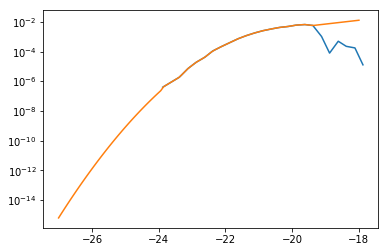

In [15]:
plt.semilogy(lf[:,0], lf[:,1])
x = np.linspace(-27, -18, 101)
plt.semilogy(x, af(x))

In [16]:
scatter = 0.2
remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)

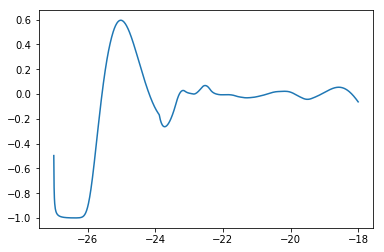

In [17]:
x, nd = af.get_number_density_table()
plt.plot(x, remainder/nd);

In [18]:
halos = np.array(halocat.halo_table)
    
nd_halos = calc_number_densities(halos['halo_vpeak'], halocat.Lbox[0])

In [19]:
full_catalog = af.match(nd_halos, scatter*LF_SCATTER_MULT)

In [20]:
mag_cut = -18 
valid_idxs = np.logical_and(~np.isnan(full_catalog), full_catalog <= mag_cut)
catalog = full_catalog[valid_idxs]

/Users/kipac-slac-loaner/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


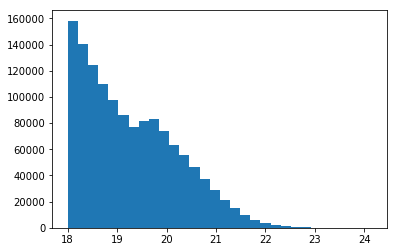

In [21]:
plt.hist(-1*catalog, bins = 30);

We want this plot to approximately match this one from Song. 

In [22]:
song_cat = np.genfromtxt('gama_z0.1_0.3_rband_absmag.ascii')

In [23]:
mags = song_cat[song_cat[:,-1] > -10000,-1 ]

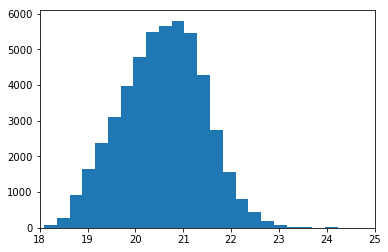

In [24]:
#plt.hist(-1*catalog, bins = 30)
plt.hist(-1*mags, bins = 30);
plt.xlim([18,25]);

In [25]:
#downsample here
hist, bin_edges = np.histogram(-1*mags, bins = 30)
downsample_idxs = set()
makeshift_hist = []
for idx, count in enumerate(hist):
    low, high = bin_edges[idx:idx+2]
    in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]
    if in_bin_idxs.shape[0] <= count:
        sampled_idxs = in_bin_idxs
    else:
        sampled_idxs = np.random.choice(in_bin_idxs, size = count, replace = False)

    downsample_idxs = downsample_idxs | set(sampled_idxs)
    
downsampled_catalog = catalog[np.array(list(downsample_idxs), dtype=int)]

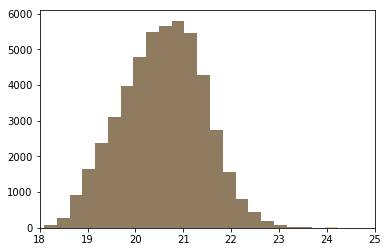

In [26]:
plt.hist(-1*downsampled_catalog, bins = bin_edges)
plt.hist(-1*mags, bins = bin_edges, alpha = 0.5);
plt.xlim([18,25]);

Yeah! let's save the indexs. 

In [27]:
downsampled_idxs_array = np.zeros_like(valid_idxs, dtype=bool)
counter = 0
for idx, val in enumerate(valid_idxs):
    if val:
        if counter in downsample_idxs:
            downsampled_idxs_array[idx] = True
        counter+=1


In [28]:
downsampled_idxs_array= np.where(valid_idxs)[0][np.array(list(downsample_idxs))]

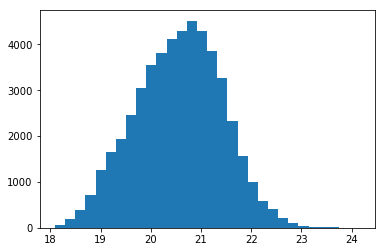

In [29]:
plt.hist(-1*full_catalog[downsampled_idxs_array], bins = 30);

In [30]:
np.savetxt('gama_matched_catalog.npy', full_catalog)
np.savetxt('gama_matched_catalog_idxs.npy', downsampled_idxs_array)